### 1. Query to extract client data

In [0]:
%sql
with base as (
  select 
    r.axa_party_id,
    r.policy_no,
    r.register_date,
    r.trmn_eff_date,
    r.wti_lob_txt,
    r.prod_lob,
    r.agt_class,
    r.isrd_brth_date,
    r.psn_age,
    r.acct_val_amt,
    r.face_amt,
    r.cash_val_amt,
    r.wc_total_assets,
    r.wc_assetmix_stocks,
    r.wc_assetmix_bonds,
    r.wc_assetmix_mutual_funds,
    r.wc_assetmix_annuity,
    r.wc_assetmix_deposits,
    r.wc_assetmix_other_assets,
    r.division_name,
    r.mkt_prod_hier,
    r.policy_status,
    r.agent_segment,
    r.channel,
    r.client_seg,
    r.client_seg_1,
    r.aum_band,
    r.business_month,
    r.branchoffice_code,
    r.agt_no,
    h.sub_product_level_1,
    h.sub_product_level_2,
    h.Product,
    row_number() over (partition by r.axa_party_id order by r.register_date asc) as rn,
    row_number() over (partition by r.axa_party_id order by r.register_date asc) = 1 as is_first_policy
  from dl_tenants_daas.us_wealth_management.wealth_management_client_metrics r
  left join (
    select distinct source_sys_id, idb_plan_cd, idb_sub_plan_cd, 
      trim(stmt_plan_typ_txt) as Product, sub_product_level_1, sub_product_level_2
    from dl_tenants_daas.us_wealth_management.wealth_management_sub_product_group
  ) h 
    on upper(r.source_sys_id) = upper(h.source_sys_id)
    and trim(upper(REPLACE(LTRIM(REPLACE(r.plan_code,'0',' ')),' ','0'))) = trim(upper(h.idb_plan_cd))
    and trim(upper(REPLACE(LTRIM(REPLACE(r.plan_subcd_code,'0',' ')),' ','0'))) = trim(upper(h.idb_sub_plan_cd))
  where r.business_month = (select max(business_month) from dl_tenants_daas.us_wealth_management.wealth_management_client_metrics)
    and r.axa_party_id is not null
    and r.policy_no is not null
),
first_second as (
  select
    axa_party_id,
    -- First policy fields
    max(case when rn = 1 then policy_no end) as policy_no,
    max(case when rn = 1 then register_date end) as register_date,
    max(case when rn = 1 then trmn_eff_date end) as trmn_eff_date,
    max(case when rn = 1 then wti_lob_txt end) as wti_lob_txt,
    max(case when rn = 1 then prod_lob end) as prod_lob,
    max(case when rn = 1 then agt_class end) as agt_class,
    max(case when rn = 1 then isrd_brth_date end) as isrd_brth_date,
    max(case when rn = 1 then psn_age end) as psn_age,
    max(case when rn = 1 then acct_val_amt end) as acct_val_amt,
    max(case when rn = 1 then face_amt end) as face_amt,
    max(case when rn = 1 then cash_val_amt end) as cash_val_amt,
    max(case when rn = 1 then wc_total_assets end) as wc_total_assets,
    max(case when rn = 1 then wc_assetmix_stocks end) as wc_assetmix_stocks,
    max(case when rn = 1 then wc_assetmix_bonds end) as wc_assetmix_bonds,
    max(case when rn = 1 then wc_assetmix_mutual_funds end) as wc_assetmix_mutual_funds,
    max(case when rn = 1 then wc_assetmix_annuity end) as wc_assetmix_annuity,
    max(case when rn = 1 then wc_assetmix_deposits end) as wc_assetmix_deposits,
    max(case when rn = 1 then wc_assetmix_other_assets end) as wc_assetmix_other_assets,
    max(case when rn = 1 then client_seg end) as client_seg,
    max(case when rn = 1 then client_seg_1 end) as client_seg_1,
    max(case when rn = 1 then aum_band end) as aum_band,
    max(case when rn = 1 then sub_product_level_1 end) as sub_product_level_1,
    max(case when rn = 1 then sub_product_level_2 end) as sub_product_level_2,
    max(case when rn = 1 then Product end) as Product,
    max(case when rn = 1 then business_month end) as business_month,
    max(case when rn = 1 then branchoffice_code end) as branchoffice_code,
    max(case when rn = 1 then agt_no end) as agt_no,
    max(case when rn = 1 then division_name end) as division_name,
    max(case when rn = 1 then mkt_prod_hier end) as mkt_prod_hier,
    max(case when rn = 1 then policy_status end) as policy_status ,
    max(case when rn = 1 then channel end) as channel,
    max(case when rn = 1 then agent_segment end) as agent_segment,
    -- Second policy fields
    max(case when rn = 2 then policy_no end) as second_policy_no,
    max(case when rn = 2 then register_date end) as second_register_date,
    max(case when rn = 2 then trmn_eff_date end) as second_trmn_eff_date,
    max(case when rn = 2 then wti_lob_txt end) as second_wti_lob_txt,
    max(case when rn = 2 then prod_lob end) as second_prod_lob,
    max(case when rn = 2 then sub_product_level_1 end) as second_sub_product_level_1,
    max(case when rn = 2 then sub_product_level_2 end) as second_sub_product_level_2,
    max(case when rn = 2 then Product end) as second_Product
  from base
  where rn <= 2
  group by axa_party_id
)
select *,
  wc_assetmix_stocks / NULLIF(wc_total_assets, 0) AS stock_allocation_ratio,
  wc_assetmix_bonds / NULLIF(wc_total_assets, 0) AS bond_allocation_ratio,
  wc_assetmix_annuity / NULLIF(wc_total_assets, 0) AS annuity_allocation_ratio,
  wc_assetmix_mutual_funds / NULLIF(wc_total_assets, 0) AS mutual_fund_allocation_ratio,
  acct_val_amt / NULLIF(wc_total_assets, 0) AS aum_to_asset_ratio,
  face_amt / NULLIF(wc_total_assets, 0) AS policy_value_to_assets_ratio,
  
  CASE 
    WHEN prod_lob = 'LIFE' THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_1 IN ('VLI', 'WL', 'UL/IUL', 'TERM', 'PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_2 LIKE '%LIFE%' THEN 'LIFE_INSURANCE'
    WHEN sub_product_level_2 IN ('VARIABLE UNIVERSAL LIFE', 'WHOLE LIFE', 'UNIVERSAL LIFE', 
                                'INDEX UNIVERSAL LIFE', 'TERM PRODUCT', 'VARIABLE LIFE', 
                                'SURVIVORSHIP WHOLE LIFE', 'MONY PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN prod_lob IN ('GROUP RETIREMENT', 'INDIVIDUAL RETIREMENT') THEN 'RETIREMENT'
    WHEN sub_product_level_1 IN ('EQUIVEST', 'RETIREMENT 401K', 'ACCUMULATOR', 
                                'RETIREMENT CORNERSTONE', 'SCS', 'INVESTMENT EDGE') THEN 'RETIREMENT'
    WHEN sub_product_level_2 LIKE '%403B%' OR sub_product_level_2 LIKE '%401%' 
         OR sub_product_level_2 LIKE '%IRA%' OR sub_product_level_2 LIKE '%SEP%' THEN 'RETIREMENT'
    WHEN Product LIKE '%IRA%' OR Product LIKE '%401%' OR Product LIKE '%403%' 
         OR Product LIKE '%SEP%' OR Product LIKE '%Accumulator%' 
         OR Product LIKE '%Retirement%' THEN 'RETIREMENT'
    WHEN prod_lob = 'BROKER DEALER' THEN 'INVESTMENT'
    WHEN sub_product_level_1 IN ('INVESTMENT PRODUCT - DIRECT', 'INVESTMENT PRODUCT - BROKERAGE', 
                                'INVESTMENT PRODUCT - ADVISORY', 'DIRECT', 'BROKERAGE', 
                                'ADVISORY', 'CASH SOLICITOR') THEN 'INVESTMENT'
    WHEN sub_product_level_2 LIKE '%Investment%' OR sub_product_level_2 LIKE '%Brokerage%' 
         OR sub_product_level_2 LIKE '%Advisory%' THEN 'INVESTMENT'
    WHEN prod_lob = 'NETWORK' THEN 'NETWORK_PRODUCTS'
    WHEN sub_product_level_1 = 'NETWORK PRODUCTS' OR sub_product_level_2 = 'NETWORK PRODUCTS' THEN 'NETWORK_PRODUCTS'
    WHEN Product LIKE '%Network%' THEN 'NETWORK_PRODUCTS'
    WHEN prod_lob = 'OTHERS' AND sub_product_level_1 = 'HAS' THEN 'DISABILITY'
    WHEN sub_product_level_2 = 'HAS - DISABILITY' THEN 'DISABILITY'
    WHEN Product LIKE '%Disability%' OR Product LIKE '%DI -%' THEN 'DISABILITY'
    WHEN prod_lob = 'OTHERS' THEN 'HEALTH'
    WHEN sub_product_level_2 = 'GROUP HEALTH PRODUCTS' THEN 'HEALTH'
    WHEN Product LIKE '%Health%' OR Product LIKE '%Medical%' OR Product LIKE '%Hospital%' THEN 'HEALTH'
    ELSE 'OTHER'
  END AS product_category,
  CASE 
    WHEN second_prod_lob IS NULL THEN NULL
    WHEN second_prod_lob = 'LIFE' THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_1 IN ('VLI', 'WL', 'UL/IUL', 'TERM', 'PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_2 LIKE '%LIFE%' THEN 'LIFE_INSURANCE'
    WHEN second_sub_product_level_2 IN ('VARIABLE UNIVERSAL LIFE', 'WHOLE LIFE', 'UNIVERSAL LIFE', 
                                'INDEX UNIVERSAL LIFE', 'TERM PRODUCT', 'VARIABLE LIFE', 
                                'SURVIVORSHIP WHOLE LIFE', 'MONY PROTECTIVE PRODUCT') THEN 'LIFE_INSURANCE'
    WHEN second_prod_lob IN ('GROUP RETIREMENT', 'INDIVIDUAL RETIREMENT') THEN 'RETIREMENT'
    WHEN second_sub_product_level_1 IN ('EQUIVEST', 'RETIREMENT 401K', 'ACCUMULATOR', 
                                'RETIREMENT CORNERSTONE', 'SCS', 'INVESTMENT EDGE') THEN 'RETIREMENT'
    WHEN second_sub_product_level_2 LIKE '%403B%' OR second_sub_product_level_2 LIKE '%401%' 
         OR second_sub_product_level_2 LIKE '%IRA%' OR second_sub_product_level_2 LIKE '%SEP%' THEN 'RETIREMENT'
    WHEN second_Product LIKE '%IRA%' OR second_Product LIKE '%401%' OR second_Product LIKE '%403%' 
         OR second_Product LIKE '%SEP%' OR second_Product LIKE '%Accumulator%' 
         OR second_Product LIKE '%Retirement%' THEN 'RETIREMENT'
    WHEN second_prod_lob = 'BROKER DEALER' THEN 'INVESTMENT'
    WHEN second_sub_product_level_1 IN ('INVESTMENT PRODUCT - DIRECT', 'INVESTMENT PRODUCT - BROKERAGE', 
                                'INVESTMENT PRODUCT - ADVISORY', 'DIRECT', 'BROKERAGE', 
                                'ADVISORY', 'CASH SOLICITOR') THEN 'INVESTMENT'
    WHEN second_sub_product_level_2 LIKE '%Investment%' OR second_sub_product_level_2 LIKE '%Brokerage%' 
         OR second_sub_product_level_2 LIKE '%Advisory%' THEN 'INVESTMENT'
    WHEN second_prod_lob = 'NETWORK' THEN 'NETWORK_PRODUCTS'
    WHEN second_sub_product_level_1 = 'NETWORK PRODUCTS' OR second_sub_product_level_2 = 'NETWORK PRODUCTS' THEN 'NETWORK_PRODUCTS'
    WHEN second_Product LIKE '%Network%' THEN 'NETWORK_PRODUCTS'
    WHEN second_prod_lob = 'OTHERS' AND second_sub_product_level_1 = 'HAS' THEN 'DISABILITY'
    WHEN second_sub_product_level_2 = 'HAS - DISABILITY' THEN 'DISABILITY'
    WHEN second_Product LIKE '%Disability%' OR second_Product LIKE '%DI -%' THEN 'DISABILITY'
    WHEN second_prod_lob = 'OTHERS' THEN 'HEALTH'
    WHEN second_sub_product_level_2 = 'GROUP HEALTH PRODUCTS' THEN 'HEALTH'
    WHEN second_Product LIKE '%Health%' OR second_Product LIKE '%Medical%' OR second_Product LIKE '%Hospital%' THEN 'HEALTH'
    ELSE 'OTHER'
  END AS second_product_category,
  CASE
    WHEN MONTH(register_date) BETWEEN 1 AND 3 THEN 'Q1'
    WHEN MONTH(register_date) BETWEEN 4 AND 6 THEN 'Q2'
    WHEN MONTH(register_date) BETWEEN 7 AND 9 THEN 'Q3'
    WHEN MONTH(register_date) BETWEEN 10 AND 12 THEN 'Q4'
    ELSE 'Unknown'
  END AS season_of_first_policy
  
from first_second

- The query pulls data from **wealth_management_client_metrics** and joins it with **wealth_management_sub_product_group** to enrich policy data with product hierarchy info. It also performs **FEATURE ENGINEERING** such as computing key ratios, categorizing policies into categories, and more.
- Filters for the latest business month and ensures valid axa_party_id and policy_no. Uses ROW_NUMBER() to rank policies per client (axa_party_id) by registration date.
- Extracts the first and second policies for each client based on the ROW_NUMBER() from the previous step.
- Uses CASE WHEN rn = 1 and rn = 2 to separate fields for the first and second policies. Aggregates data using MAX() to get one row per client.




**FEATURE ENGINEERING such as:**

**1.** Computing ratios:  

- `stock_allocation_ratio`: Measures the proportion of total assets invested in stocks. Indicates risk appetite - higher ratio suggests a more aggressive investor, 

- `bond_allocation_ratio`: Shows how much is allocated to bonds, which are typically lower-risk.
Helps identify income-focused or risk-averse investors, 

- `annuity_allocation_ratio`: Reflects investment in annuities, often used for retirement income.
Indicates long-term financial planning and income security preferences, 

- `mutual_fund_allocation_ratio`: Measures exposure to mutual funds, which offer diversification.
Useful for identifying clients who prefer managed portfolios, 

- `aum_to_asset_ratio`: Indicates how much of a client’s wealth is managed by the firm.
Helps assess wallet share and potential for upselling or deepening relationships, 

- `policy_value_to_assets_ratio`: Shows how much of a client’s total assets are covered by insurance policies.
Useful for evaluating underinsurance or overinsurance.

**2.** Season of first policy (Q1 - Q4) for seasonality patterns

**3.** Categorize products into broader product categories based on multiple fields like prod_lob, sub_product_level_1, sub_product_level_2, and Product for accurate and familiar grouping: 

**`LIFE_INSURANCE`**
Assigned when:

- prod_lob = 'LIFE'
- sub_product_level_1 is one of: 'VLI', 'WL', 'UL/IUL', 'TERM', 'PROTECTIVE PRODUCT'
- sub_product_level_2 contains 'LIFE' or matches specific life insurance types like:
'VARIABLE UNIVERSAL LIFE', 'WHOLE LIFE', 'UNIVERSAL LIFE', 'INDEX UNIVERSAL LIFE', 'TERM PRODUCT', 'VARIABLE LIFE', 'SURVIVORSHIP WHOLE LIFE', 'MONY PROTECTIVE PRODUCT'

**`RETIREMENT`**
Assigned when:

- prod_lob is 'GROUP RETIREMENT' or 'INDIVIDUAL RETIREMENT'
- sub_product_level_1 includes retirement-related products like 'EQUIVEST', 'RETIREMENT 401K', 'ACCUMULATOR', 'RETIREMENT CORNERSTONE', 'SCS', 'INVESTMENT EDGE'
- sub_product_level_2 or Product contains retirement keywords like '403B', '401', 'IRA', 'SEP', 'Accumulator', 'Retirement'

**`INVESTMENT`**
Assigned when:

- prod_lob = 'BROKER DEALER'
- sub_product_level_1 includes investment types like 'INVESTMENT PRODUCT - DIRECT', 'BROKERAGE', 'ADVISORY', 'CASH SOLICITOR'
- sub_product_level_2 contains 'Investment', 'Brokerage', 'Advisory'

**`NETWORK_PRODUCTS`**
Assigned when:

- prod_lob = 'NETWORK'
- sub_product_level_1 or sub_product_level_2 is 'NETWORK PRODUCTS'
- Product contains 'Network'

**`DISABILITY`**
Assigned when:

- prod_lob = 'OTHERS' and sub_product_level_1 = 'HAS'
- sub_product_level_2 = 'HAS - DISABILITY'
- Product contains 'Disability' or starts with 'DI -'

**`HEALTH`**
Assigned when:

- prod_lob = 'OTHERS' (fallback if not matched to disability)
- sub_product_level_2 = 'GROUP HEALTH PRODUCTS'
- Product contains 'Health', 'Medical', or 'Hospital' 

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = _sqldf.toPandas()

# age at first policy (calculated from dates)
df['register_date'] = pd.to_datetime(df['register_date'], errors='coerce')
df['isrd_brth_date'] = pd.to_datetime(df['isrd_brth_date'], errors='coerce')
df['age_at_first_policy'] = (df['register_date'] - df['isrd_brth_date']).dt.days / 365.25

# age at second policy
df['second_register_date'] = pd.to_datetime(df['second_register_date'], errors='coerce')
df['age_at_second_policy'] = (df['second_register_date'] - df['isrd_brth_date']).dt.days / 365.25

# time gap between first and second policy
df['years_to_second'] = (df['second_register_date'] - df['register_date']).dt.days / 365.25


Here, the Feature Engineering is done to compute 

`age_at_first_policy` for Customer lifecycle insights
 
`years_to_second` for predictive timing

In [0]:
display(df.head(5))

axa_party_id,policy_no,register_date,trmn_eff_date,wti_lob_txt,prod_lob,agt_class,isrd_brth_date,psn_age,acct_val_amt,face_amt,cash_val_amt,wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,client_seg,client_seg_1,aum_band,sub_product_level_1,sub_product_level_2,Product,business_month,branchoffice_code,agt_no,division_name,mkt_prod_hier,policy_status,channel,agent_segment,second_policy_no,second_register_date,second_trmn_eff_date,second_wti_lob_txt,second_prod_lob,second_sub_product_level_1,second_sub_product_level_2,second_Product,stock_allocation_ratio,bond_allocation_ratio,annuity_allocation_ratio,mutual_fund_allocation_ratio,aum_to_asset_ratio,policy_value_to_assets_ratio,product_category,second_product_category,season_of_first_policy,age_at_first_policy,age_at_second_policy,years_to_second
00BK05RY276VO5F4XXXX,011635841,1943-03-01T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1937-07-12T00:00:00.000Z,88.0,3943.0,1000.0,3943.0,202320.0,33245.0,1083.0,53783.0,12489.0,100080.0,1640.0,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Life Paid-Up Whole Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.16431890075128508,0.005352906287069988,0.06172894424673784,0.2658313562672993,0.01948892843020957,0.0049426650850138395,LIFE_INSURANCE,null,Q1,5.634496919917864,null,null
00BK05RY287CY5V7XXXX,013575860,1951-10-18T00:00:00.000Z,null,Life Insurance,LIFE,NON CAREER AGENTS,1934-06-11T00:00:00.000Z,91.0,15990.0,2000.0,15990.0,2068354.0,799767.0,79709.0,763990.0,67436.0,308563.0,48889.0,1-2.99m,Life Legacies,<$25K,WL,Whole Life,Twenty Payment Life,202510,173,097952,Southeast Complex,Individual,Active,Retail,Generalist,null,null,null,null,null,null,null,null,0.38666833627125724,0.03853740703960734,0.032603703234552694,0.36937100709066245,0.007730784962342036,9.669524655837444E-4,LIFE_INSURANCE,null,Q4,17.352498288843258,null,null
00BK05RY28JZ21Z8XXXX,014157974,1953-09-09T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1944-09-28T00:00:00.000Z,81.0,896.0,1000.0,896.0,308589.0,31323.0,440.0,56344.0,17575.0,199339.0,3568.0,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Twenty Payment Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.10150394213662833,0.0014258447319897987,0.05695277537436526,0.18258589904371186,0.002903538363324681,0.0032405562090677244,LIFE_INSURANCE,null,Q3,8.947296372347708,null,null
00BK05RY290NRYCGXXXX,014016911,1953-03-15T00:00:00.000Z,2024-10-09,Life Insurance,LIFE,NON CAREER AGENTS,1926-09-17T00:00:00.000Z,99.0,0.0,3000.0,0.0,227359.96,45936.42,3630.31,92854.07,15590.77,64804.15,4544.23,200-399k,Strategic Spenders,<$25K,WL,Whole Life,Ordinary Life,202510,572,097975,Mid Atlantic Complex,Individual,Inactive,Retail,Generalist,014817132,1955-08-03T00:00:00.000Z,null,Life Insurance,LIFE,WL,Whole Life,Twenty Payment Life,0.20204269916303644,0.01596723539184296,0.06857306801074385,0.4084011538355303,0.0,0.01319493546708928,LIFE_INSURANCE,LIFE_INSURANCE,Q1,26.491444216290212,28.876112251882272,2.3846680355920604
00BK05RY29CCVWR9XXXX,015428023,1957-02-13T00:00:00.000Z,null,Life Insurance,LIFE,ESF - EXPERIENCED SALESFORCE,1957-01-17T00:00:00.000Z,69.0,1726.0,1000.0,1726.0,852038.0,108432.0,8730.0,374614.0,82524.0,269311.0,8427.0,400-999k,Next Chapters,<$25K,WL,Whole Life,Twenty Payment Life,202510,83,112582,Division 8,Individual,Active,Branch Assist,Generalist,null,null,null,null,null,null,null,null,0.12726192963224645,0.010246021891042418,0.09685483511298792,0.439668183813398,0.002025731246728432,0.001173656574002568,LIFE_INSURANCE,null,Q1,0.07392197125256673,null,null


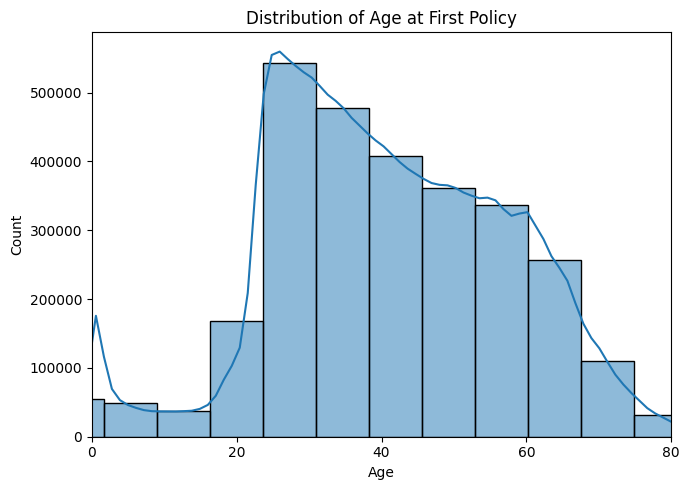

In [0]:
# Age distribution at first policy (calculated from dates)

plt.figure(figsize=(7,5))
sns.histplot(df['age_at_first_policy'].dropna(), bins=30, kde=True)
plt.title('Distribution of Age at First Policy')
plt.xlabel('Age')
plt.xlim(0, 80)
plt.xticks(range(0, 81, 20))
plt.tight_layout()
display(plt.gcf())
plt.close()

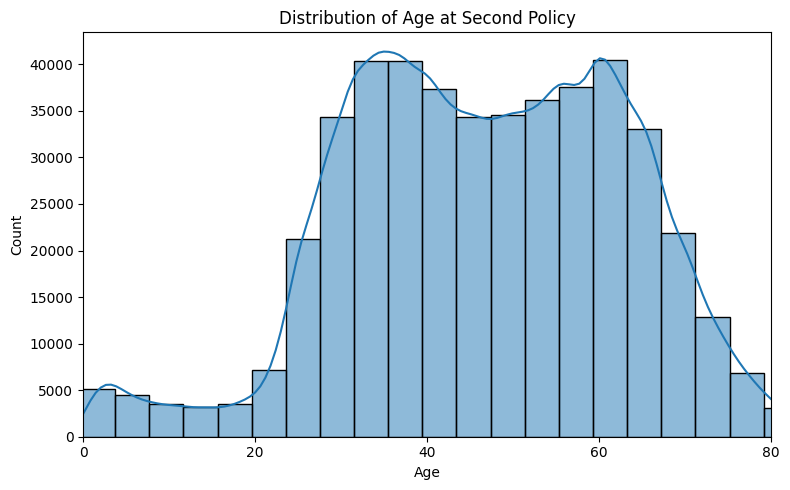

In [0]:
# Age distribution at second policy (calculated from dates)

plt.figure(figsize=(8,5))
sns.histplot(df['age_at_second_policy'].dropna(), bins=30, kde=True)
plt.title('Distribution of Age at Second Policy')
plt.xlabel('Age')
plt.xlim(0, 80)
plt.xticks(range(0, 81, 20))
plt.tight_layout()
display(plt.gcf())
plt.close()

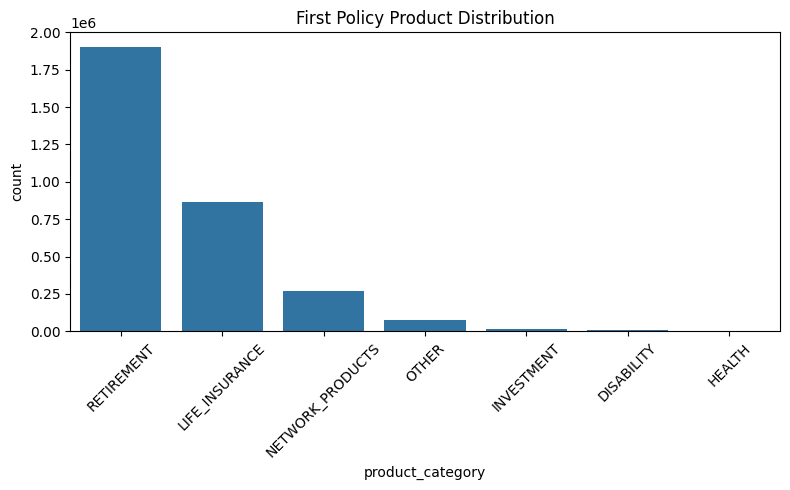

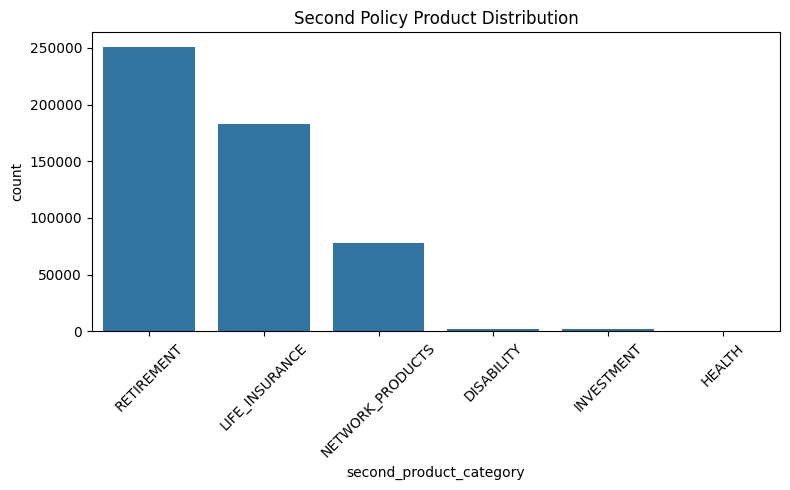

In [0]:
# Product type distribution for first and second policy

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='product_category', order=df['product_category'].value_counts().index)
plt.title('First Policy Product Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='second_product_category', order=df['second_product_category'].value_counts().index)
plt.title('Second Policy Product Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

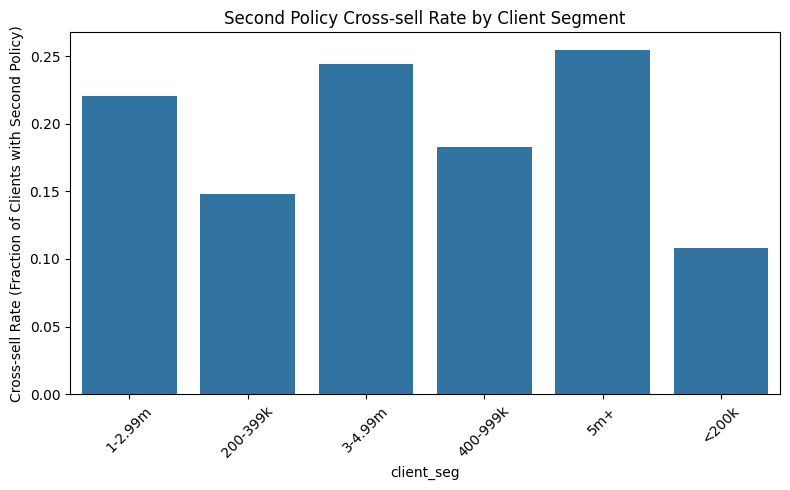

In [0]:
# Client segment vs. second policy cross-sell rate
# This plot shows, for each client segment, the proportion of clients who obtained a second policy (cross-sell rate).
# The y-axis represents the cross-sell rate, which is a fraction between 0 and 1 (i.e., the percentage of clients with a second policy in each segment).

cross_sell_rate = df.groupby('client_seg')['second_policy_no'].apply(lambda x: x.notnull().mean()).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=cross_sell_rate, x='client_seg', y='second_policy_no')
plt.title('Second Policy Cross-sell Rate by Client Segment')
plt.ylabel('Cross-sell Rate (Fraction of Clients with Second Policy)')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

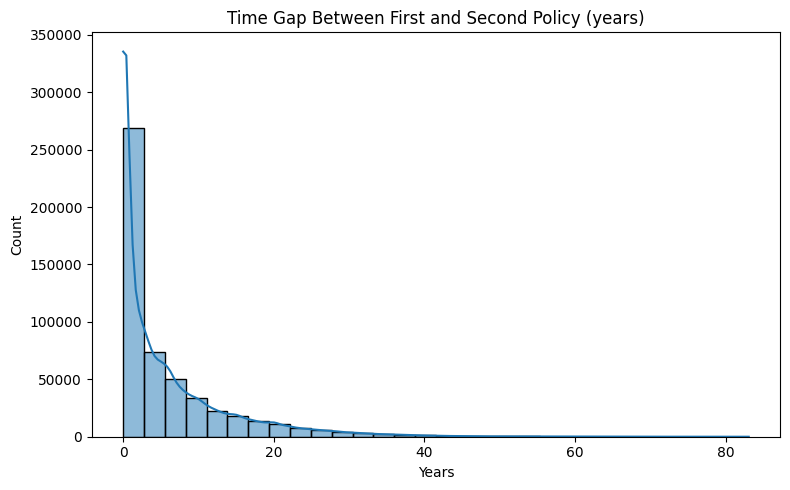

In [0]:
# Time gap between first and second policy

plt.figure(figsize=(8,5))
sns.histplot(df['years_to_second'].dropna(), bins=30, kde=True)
plt.title('Time Gap Between First and Second Policy (years)')
plt.xlabel('Years')
plt.tight_layout()
display(plt.gcf())
plt.close()

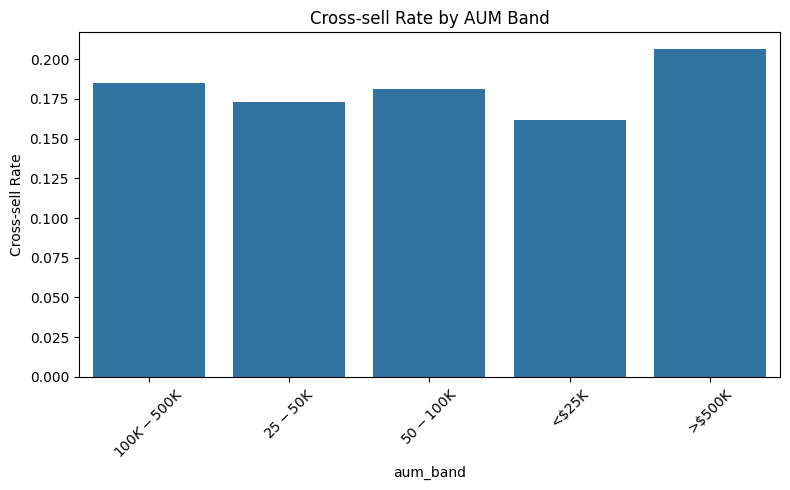

In [0]:

# AUM band vs. cross-sell rate

aum_cross = df.groupby('aum_band')['second_policy_no'].apply(lambda x: x.notnull().mean()).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=aum_cross, x='aum_band', y='second_policy_no')
plt.title('Cross-sell Rate by AUM Band')
plt.ylabel('Cross-sell Rate')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

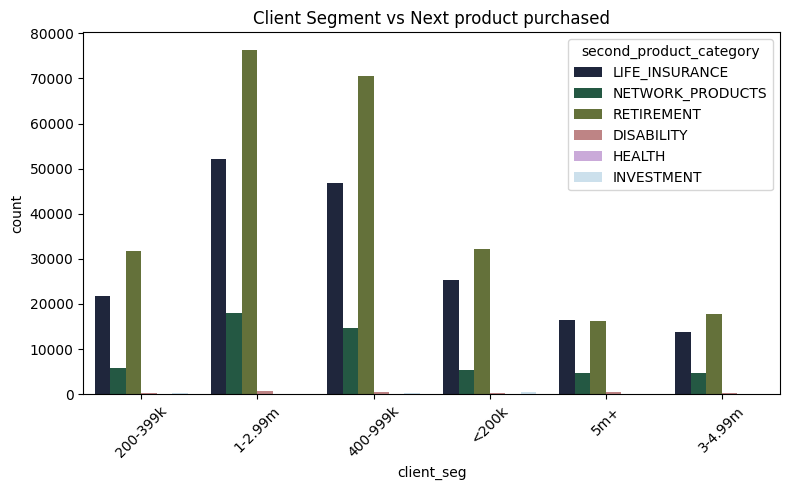

In [0]:
# client segment vs next product purchased

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="client_seg", hue="second_product_category", palette="cubehelix")
plt.xticks(rotation=45)
plt.title("Client Segment vs Next product purchased")
plt.tight_layout()
display(plt.gcf())
plt.close()

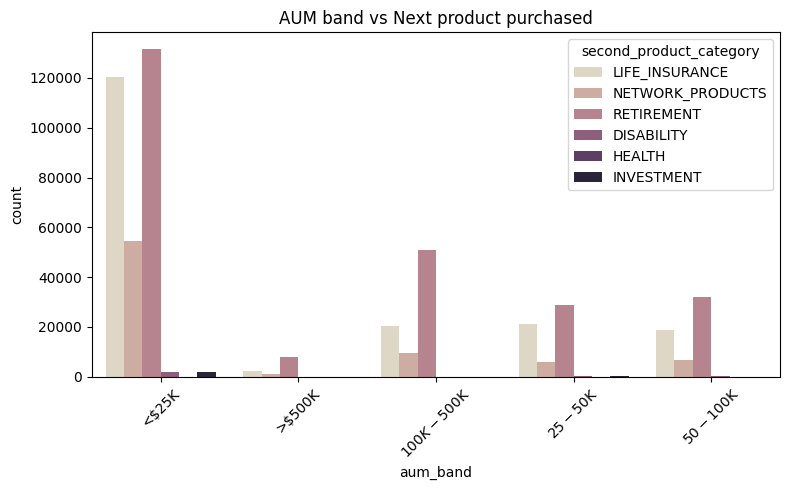

In [0]:
# aum_band segment vs next product purchased

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="aum_band", hue="second_product_category", palette="ch:s=-.2,r=.6")
plt.xticks(rotation=45)
plt.title("AUM band vs Next product purchased")
plt.tight_layout()
display(plt.gcf())
plt.close()

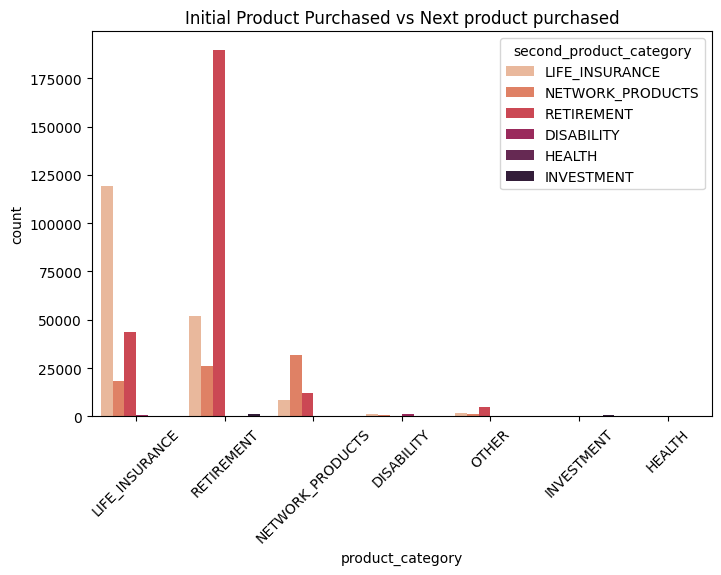

In [0]:
# Initial product purchased vs next product purchased

plt.figure(figsize=(8, 5))
sns.countplot(data=df,x="product_category",hue="second_product_category",palette="rocket_r")
plt.xticks(rotation=45)
plt.title("Initial Product Purchased vs Next product purchased")
plt.show()

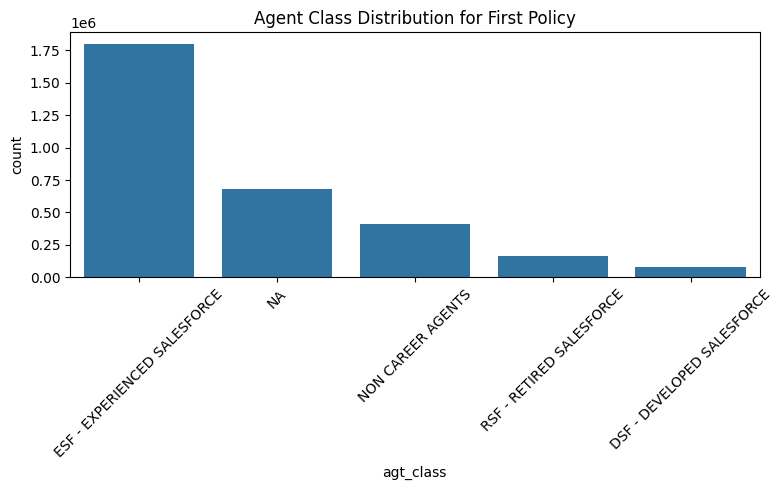

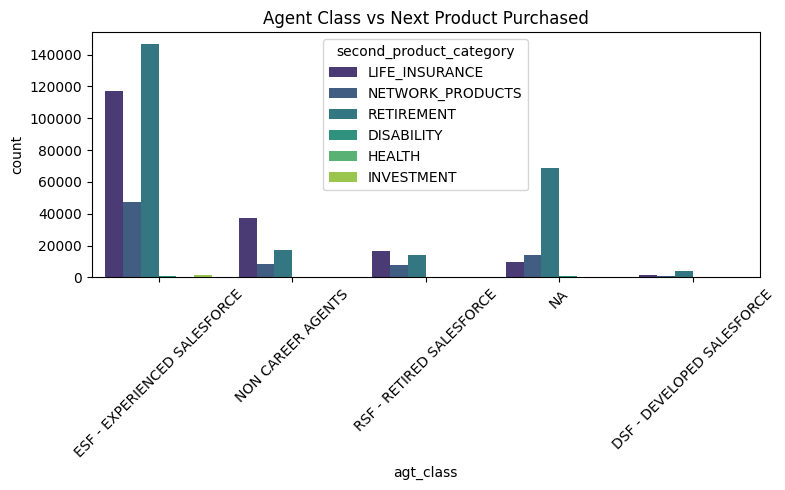

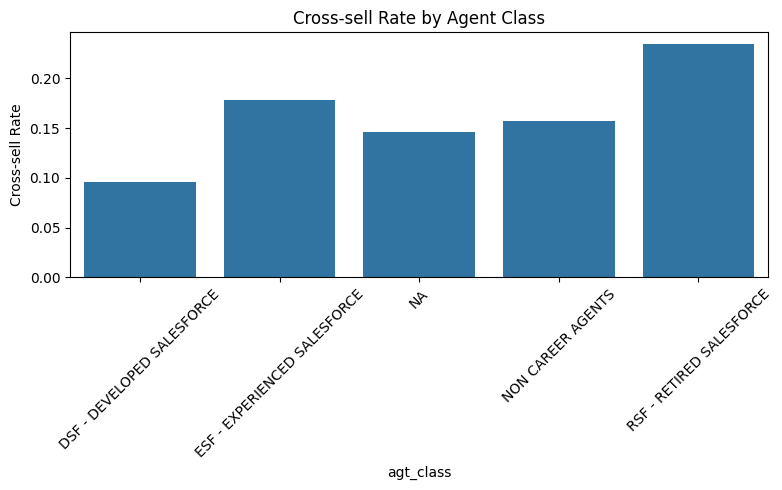

In [0]:
# Agent class distribution for first policy and next product purchased and cross sell rate by agent class

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='agt_class', order=df['agt_class'].value_counts().index)
plt.title('Agent Class Distribution for First Policy')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

plt.figure(figsize=(8,5))
sns.countplot(data=df, x='agt_class', hue='second_product_category', palette='viridis')
plt.title('Agent Class vs Next Product Purchased')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

# Cross-sell rate by agent class
cross_sell_by_agt =  df.groupby('agt_class')['second_policy_no'].apply(lambda x: x.notnull().mean()).reset_index().rename(columns={'second_policy_no': 'is_cross_sell'})
plt.figure(figsize=(8,5))
sns.barplot(data=cross_sell_by_agt, x='agt_class', y='is_cross_sell')
plt.title('Cross-sell Rate by Agent Class')
plt.ylabel('Cross-sell Rate')
plt.xticks(rotation=45)
plt.tight_layout()
display(plt.gcf())
plt.close()

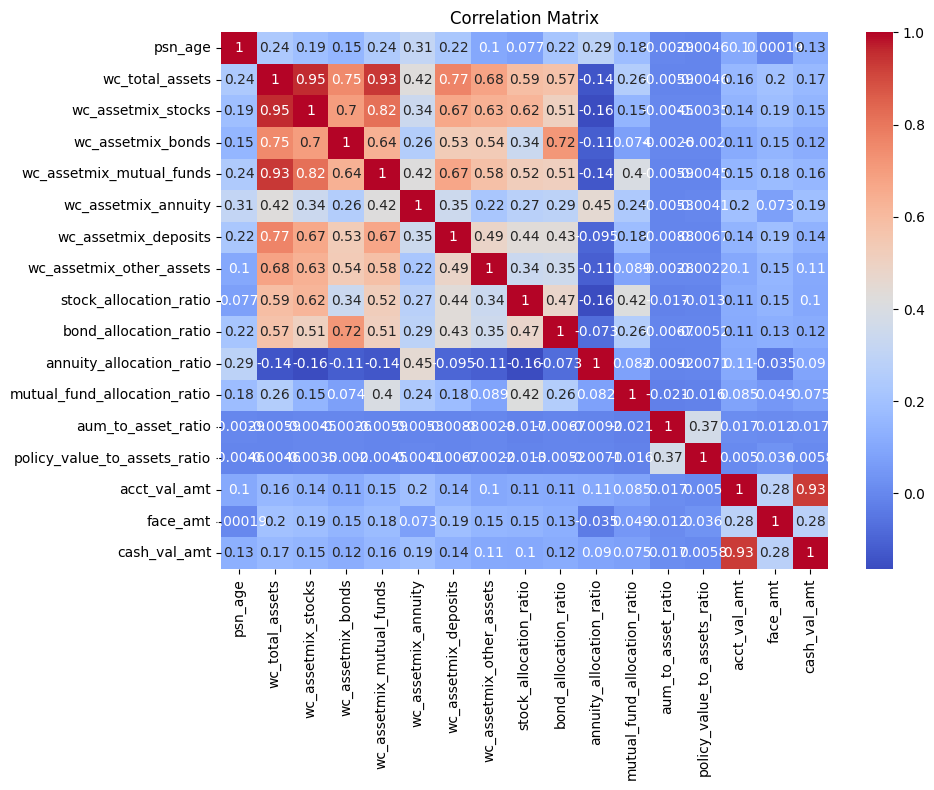

In [0]:
# Correlation matrix

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['years_to_second', 'days_to_second', 'age_at_first_policy', 'age_at_second_policy']
numerical_features = [col for col in numerical_features if col not in exclude_cols]

for col in ['acct_val_amt', 'face_amt', 'cash_val_amt']:
    if col in df.columns and col not in numerical_features:
        numerical_features = list(numerical_features) + [col]

corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
display(plt.gcf())
plt.close()

### **DATA CLEANING**

In [0]:
display(df.columns)

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Dropping duplicates is important in ML to prevent data leakage, reduce bias, and ensure the model does not overfit to repeated samples.

In [0]:
# Remove duplicate rows
df = df.drop_duplicates()


Handle missing values - missing values in critical features can lead to unreliable model training, errors during fitting, or biased results.
Removing such rows ensures data quality and model integrity.

Separating numerical and categorical columns.



In [0]:
# Handle missing values

# drop rows with missing target or critical features
critical_cols = ['product_category']
df = df.dropna(subset=critical_cols)

num_cols = df.select_dtypes(include=['float64', 'int64']).columns
display(num_cols)

cat_cols = df.select_dtypes(include=['object']).columns
display(cat_cols)

Index(['psn_age', 'wc_total_assets', 'wc_assetmix_stocks', 'wc_assetmix_bonds',
       'wc_assetmix_mutual_funds', 'wc_assetmix_annuity',
       'wc_assetmix_deposits', 'wc_assetmix_other_assets',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy_value_to_assets_ratio',
       'age_at_first_policy', 'age_at_second_policy', 'years_to_second'],
      dtype='object')

Index(['axa_party_id', 'policy_no', 'trmn_eff_date', 'wti_lob_txt', 'prod_lob',
       'agt_class', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'branchoffice_code', 'agt_no', 'division_name', 'mkt_prod_hier',
       'policy_status', 'channel', 'agent_segment', 'second_policy_no',
       'second_trmn_eff_date', 'second_wti_lob_txt', 'second_prod_lob',
       'second_sub_product_level_1', 'second_sub_product_level_2',
       'second_Product', 'product_category', 'second_product_category',
       'season_of_first_policy'],
      dtype='object')

The provided data shows high positive skewness for all financial numerical columns, indicating most values are concentrated at the lower end with a long right tail.
Generally, tree basedmodels (random forest or xgboost) handle skewed data and outliers well without needing normalization or transformation.

But, as the data is extremely skewwd, it could lead  to: 
- Less optimal splits early in the tree.
- Cause overfitting if a few large values dominate the feature space.
- Reduce model interpretability, especially in feature importance

Hence, to improve model performance and reliability, we will apply log1p.

In [0]:
import scipy.stats as stats
import numpy as np

# List of financial columns
financial_cols = [col for col in df.columns if col.startswith('wc_')] + ['face_amt', 'cash_val_amt', 'acct_val_amt']
financial_cols = [col for col in financial_cols if col in df.columns]

# Compute skewness for each financial column
skewness_dict = {col: stats.skew(df[col].dropna()) for col in financial_cols}
skew_df = pd.DataFrame([skewness_dict])
display(skew_df)

# Apply log1p transformation to reduce skewness
for col in financial_cols:
    df[f'log_{col}'] = np.log1p(df[col])

# Compute skewness for each log-transformed financial column
log_skewness_dict = {f'log_{col}': stats.skew(df[f'log_{col}'].dropna()) for col in financial_cols}
log_skew_df = pd.DataFrame([log_skewness_dict])
display(log_skew_df)

wc_total_assets,wc_assetmix_stocks,wc_assetmix_bonds,wc_assetmix_mutual_funds,wc_assetmix_annuity,wc_assetmix_deposits,wc_assetmix_other_assets,face_amt,cash_val_amt,acct_val_amt
4.08634499415451,5.426911578366013,15.679434305597216,4.440412142368163,17.826015942846972,7.111353238054384,26.377674115574663,53.31286874305497,40.50468430702235,35.92179677587274


/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
/databricks/python/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


log_wc_total_assets,log_wc_assetmix_stocks,log_wc_assetmix_bonds,log_wc_assetmix_mutual_funds,log_wc_assetmix_annuity,log_wc_assetmix_deposits,log_wc_assetmix_other_assets,log_face_amt,log_cash_val_amt,log_acct_val_amt
-3.367337621230025,-1.7649898832555317,-0.923430199287643,-2.097734626521522,-1.8956302655056925,-4.9065056441033486,-1.1477874546082587,-1.3141103813619393,0.6445987022520583,-0.6954772374707812


Standardizing date columns ensures all date fields are in a consistent datetime format,
which is necessary for reliable feature engineering (e.g., calculating durations, extracting year/month).

Removing outliers in numerical features (e.g., age_at_first_policy) prevents extreme values from distracting the model during training,
leading to more robust and generalizable models.


In [0]:
# Standardize date columns
date_cols = ['register_date', 'second_register_date', 'isrd_brth_date', 'trmn_eff_date', 'second_trmn_eff_date']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Remove outliers in numerical features
df = df[(df['age_at_first_policy'] >= 0) & (df['age_at_first_policy'] <= 100)]

# Categorical encoding (LabelEncoder is correct for tree models, but for Spark MLlib, use StringIndexer)
cat_cols = [
    'product_category', 'prod_lob', 'client_seg', 'aum_band', 'agt_class', 'season_of_first_policy', 'client_seg_1', 'division_name','mkt_prod_hier', 'policy_status', 'channel', 'agent_segment']
for col in cat_cols + ['second_product_category']:
    if col in df.columns:
        df[col] = df[col].astype(str)


In [0]:
df.columns

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Dropping highly correlated numerical features is important because:
1. It reduces multicollinearity, which can negatively impact model interpretability and stability.
2. It prevents redundant information, making models more efficient and less prone to overfitting.
3. It improves training speed and can enhance generalization by reducing noise from duplicate signals.


In [0]:
df = df.drop(columns=[
    'log_wc_assetmix_stocks',
    'log_wc_assetmix_bonds',
    'log_wc_assetmix_mutual_funds',
    'log_wc_assetmix_deposits',
    'log_wc_assetmix_other_assets',
    'log_acct_val_amt'
])

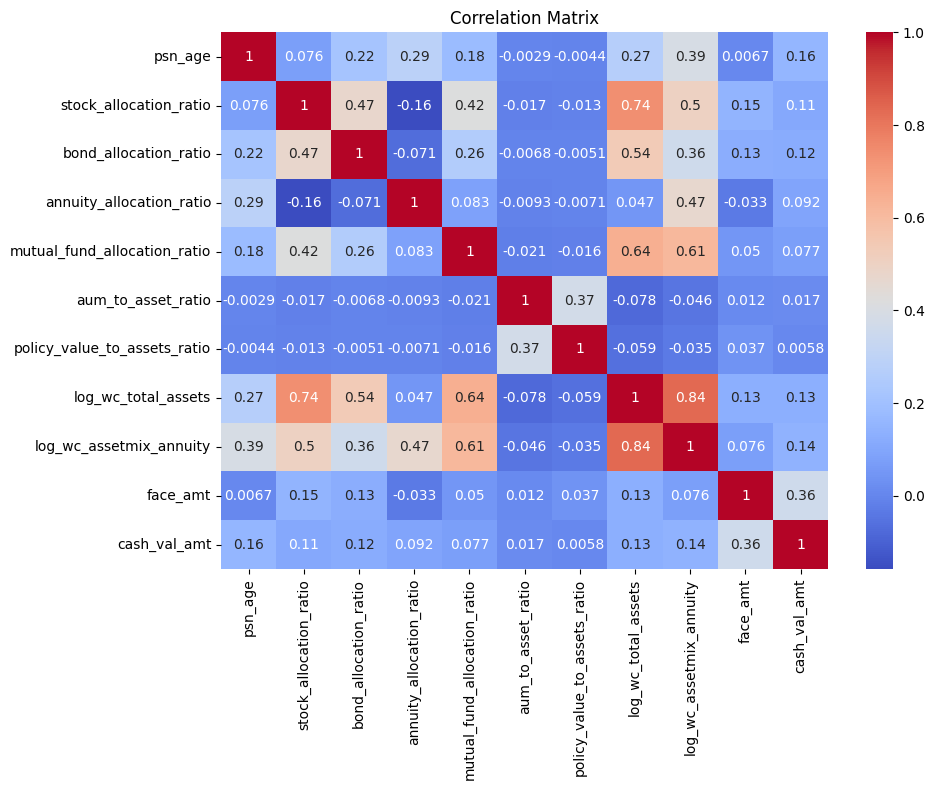

In [0]:
# Correlation matrix after removing highly correlated features

numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
exclude_cols = ['years_to_second', 'days_to_second', 'age_at_first_policy', 'age_at_second_policy', 'log_wc_assetmix_stocks', 'log_wc_assetmix_bonds', 'log_wc_assetmix_mutual_funds', 'log_wc_assetmix_deposits', 'log_wc_assetmix_other_assets']
numerical_features = [col for col in numerical_features if col not in exclude_cols and not col.startswith('wc')]

for col in ['face_amt', 'cash_val_amt']:
    if col in df.columns and col not in numerical_features:
        numerical_features = list(numerical_features) + [col]

corr_matrix = df[numerical_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.tight_layout()
display(plt.gcf())
plt.close()

In [0]:
df.columns

Index(['axa_party_id', 'policy_no', 'register_date', 'trmn_eff_date',
       'wti_lob_txt', 'prod_lob', 'agt_class', 'isrd_brth_date', 'psn_age',
       'acct_val_amt', 'face_amt', 'cash_val_amt', 'wc_total_assets',
       'wc_assetmix_stocks', 'wc_assetmix_bonds', 'wc_assetmix_mutual_funds',
       'wc_assetmix_annuity', 'wc_assetmix_deposits',
       'wc_assetmix_other_assets', 'client_seg', 'client_seg_1', 'aum_band',
       'sub_product_level_1', 'sub_product_level_2', 'Product',
       'business_month', 'branchoffice_code', 'agt_no', 'division_name',
       'mkt_prod_hier', 'policy_status', 'channel', 'agent_segment',
       'second_policy_no', 'second_register_date', 'second_trmn_eff_date',
       'second_wti_lob_txt', 'second_prod_lob', 'second_sub_product_level_1',
       'second_sub_product_level_2', 'second_Product',
       'stock_allocation_ratio', 'bond_allocation_ratio',
       'annuity_allocation_ratio', 'mutual_fund_allocation_ratio',
       'aum_to_asset_ratio', 'policy

Medium Imputation performed for the numerical (ratio) columns - this ensures that all records are usable, improving training efficiency and accuracy.

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, Imputer
from pyspark.ml.classification import GBTClassifier, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from synapse.ml.lightgbm import LightGBMClassifier

# Median imputation for allocation ratio columns
allocation_cols = [
    'stock_allocation_ratio', 'bond_allocation_ratio', 'annuity_allocation_ratio',
    'mutual_fund_allocation_ratio', 'aum_to_asset_ratio', 'policy_value_to_assets_ratio'
]

if 'spark' not in globals() or spark is None:
    raise RuntimeError("Spark context is not available. Please run this cell in a Databricks notebook with an active cluster.")

if not hasattr(df, 'columns'):
    raise RuntimeError("df is not defined or not a pandas DataFrame.")

imputer = Imputer(
    inputCols=[c for c in allocation_cols if c in df.columns],
    outputCols=[c for c in allocation_cols if c in df.columns],
    strategy="median"
)
spark_df = spark.createDataFrame(df)
df_imputed = imputer.fit(spark_df).transform(spark_df)
spark_df = df_imputed
display(spark_df)

Function for adding Propensity features - we're creating propensity features using train data and adding them to train and unseen data


In [0]:
def add_propensity_features(df, lookup_prod, lookup_mode, lookup_agent, lookup_branch):
    df_with_features = df.withColumnRenamed("product_category", "prod_code")
    df_with_features = df_with_features.join(lookup_prod, on="prod_code", how="left")
    df_with_features = df_with_features.join(lookup_mode, on="prod_code", how="left")
    df_with_features = df_with_features.join(lookup_agent, on=["agt_no", "prod_code"], how="left")
    df_with_features = df_with_features.join(lookup_branch, on=["branchoffice_code", "prod_code"], how="left")
    df_with_features = df_with_features.na.fill(0, [
        "p1_cross_sell_popularity",
        "agent_p1_cross_sell_count",
        "branch_p1_cross_sell_count"
    ])
    df_with_features = df_with_features.na.fill("UNKNOWN", ["p1_most_common_next_prod"])
    df_with_features = df_with_features.withColumnRenamed("prod_code", "product_category")
    return df_with_features

Using rows with a second policy for training


In [0]:
log_financial_cols = [
    'log_wc_total_assets', 'log_wc_assetmix_annuity', 'log_wc_assetmix_other_assets',
    'log_face_amt', 'log_cash_val_amt'
]

# Train only on rows with second_product_category (i.e., with a second policy)
train_df = spark_df.filter(col("second_product_category").isNotNull())
for colname in ['age_at_first_policy', 'years_to_second'] + [col for col in log_financial_cols if col in df.columns]:
    train_df = train_df.filter(col(colname).isNotNull())

In [0]:
# Split train_df into training and validation sets
train_data, val_data = train_df.randomSplit([0.8, 0.2], seed=42)

In [0]:
# Defining a new df for creating propensity features

cross_sell_history_df = train_data.select(
    F.col("product_category").alias("first_prod_code"),
    F.col("second_product_category").alias("second_prod_code"),
    "agt_no",
    "branchoffice_code"
)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

FEATURE ENGINEERING - PROPENSITY FEATURES
- Product propensity - Given product A was sold first, how likely is product B is to be sold next  --- Tells the global cross sell tendency
- Agent Propensity - How often does this agent sell product A and then any product B --- incorporates seller behavior and identifies agents with strong patterns
- Branch Propensity - How often does a specific branch sell product A and then product B --- captures branch influence


In [0]:
# Feature: Most common next product (mode)
prod_total_cross_sells = cross_sell_history_df.groupBy("first_prod_code") \
    .count() \
    .withColumnRenamed("count", "p1_total_cross_sells")
propensity_prod_df = prod_total_cross_sells.withColumnRenamed("first_prod_code", "prod_code") \
    .withColumnRenamed("p1_total_cross_sells", "p1_cross_sell_popularity")
display(propensity_prod_df)

path_counts = cross_sell_history_df.groupBy("first_prod_code", "second_prod_code").count()
window_spec = Window.partitionBy("first_prod_code").orderBy(F.col("count").desc())
most_common_path_df = path_counts.withColumn("rank", F.row_number().over(window_spec)) \
    .filter(F.col("rank") == 1) \
    .select(
        F.col("first_prod_code").alias("prod_code"),
        F.col("second_prod_code").alias("p1_most_common_next_prod")
    )
display(most_common_path_df)

# Feature: Agent-level cross-sell count
propensity_agent_df = cross_sell_history_df.groupBy("agt_no", "first_prod_code") \
    .count() \
    .withColumnRenamed("count", "agent_p1_cross_sell_count") \
    .withColumnRenamed("first_prod_code", "prod_code")
display(propensity_agent_df)

# Feature: Branch-level cross-sell count
propensity_branch_df = cross_sell_history_df.groupBy("branchoffice_code", "first_prod_code") \
    .count() \
    .withColumnRenamed("count", "branch_p1_cross_sell_count") \
    .withColumnRenamed("first_prod_code", "prod_code")
display(propensity_branch_df)

In [0]:
# Add propensity features to train and validation sets
train_df_final = add_propensity_features(
    train_data, propensity_prod_df, most_common_path_df, propensity_agent_df, propensity_branch_df
)
val_df_final = add_propensity_features(
    val_data, propensity_prod_df, most_common_path_df, propensity_agent_df, propensity_branch_df
)

Gather columns for training

In [0]:
#
# These features are not used in the model, but are used for validationIndicatorCol param in LightGBM ONLY
train_df_final = train_df_final.withColumn("is_validation", F.lit(False))
val_df_final = val_df_final.withColumn("is_validation", F.lit(True))
combined_train_val = train_df_final.unionByName(val_df_final)
#

# Define categorical columns (add p1_most_common_next_prod)
cat_cols = cat_cols + ['p1_most_common_next_prod']

# Define feature columns
feature_cols = (
    [f"{c}_idx" for c in cat_cols] +
    [
        'age_at_first_policy', 'years_to_second',
        'stock_allocation_ratio', 'bond_allocation_ratio', 'annuity_allocation_ratio',
        'mutual_fund_allocation_ratio', 'aum_to_asset_ratio', 'policy_value_to_assets_ratio'
    ] +
    [col for col in log_financial_cols if col in df.columns] +
    [
        "p1_cross_sell_popularity",
        "agent_p1_cross_sell_count",
        "branch_p1_cross_sell_count"
    ]
)

In [0]:
# Index categorical columns
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]
label_indexer = StringIndexer(
    inputCol="second_product_category", outputCol="label", handleInvalid="keep"
)

assembler = VectorAssembler(
    inputCols=feature_cols, outputCol="features", handleInvalid="keep"
)

In [0]:
### GBT CLASSIFIER TRAINING

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, maxDepth=5)
ovr = OneVsRest(classifier=gbt, labelCol="label", featuresCol="features")
pipeline_ovr = Pipeline(stages=indexers + [label_indexer, assembler, ovr])

model = pipeline_ovr.fit(train_df_final)

# Get feature importances from the first binary GBT model in OneVsRest
gbt_model = model.stages[-1].models[0]

The parameter 'isUnbalance' handles the class imbalance in LightGBM when set to _True_

In [0]:
### LIGHTGBM TRAINING

lgbm = LightGBMClassifier(
    labelCol="label",
    featuresCol="features",
    isUnbalance=True,
    validationIndicatorCol="is_validation"
)
lgbm.setParams(
    maxDepth=7,
    objective="multiclass",
    numClass=6,
    learningRate  =0.05,
    numIterations=1000,
    earlyStoppingRound=50,
    numLeaves=40,
    baggingFraction=0.8,
    baggingFreq=1,
    featureFraction=0.8
)

pipeline_ovr = Pipeline(stages=indexers + [label_indexer, assembler, lgbm])
model = pipeline_ovr.fit(combined_train_val)

# Get feature importances for LightGBM
gbt_model = model.stages[-1]

In [0]:
# FEATURE IMPORTANCE AND DISPLAY PREDICTED SECOND PRODUCT

importances = gbt_model.getFeatureImportances()
import pandas as pd
feature_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances.toArray()
}).sort_values("importance", ascending=False)
display(spark.createDataFrame(feature_importance))

predictions_val = model.transform(val_df_final)
from pyspark.ml.feature import IndexToString
label_converter = IndexToString(
    inputCol="prediction",
    outputCol="predicted_second_product_category",
    labels=model.stages[-3].labels
)
final_predictions = label_converter.transform(predictions_val)
display(final_predictions.select("axa_party_id", "policy_no", "product_category", "predicted_second_product_category"))

Storing the Propensity features in the catalog explorer for pipeline preprocessing

In [0]:
propensity_prod_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_prod_df")

most_common_path_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.most_common_path_df")

propensity_agent_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_agent_df")

propensity_branch_df.write.format("delta").mode("overwrite").saveAsTable("eda_smartlist.us_wealth_management_smartlist.propensity_branch_df")

Registering the model in the catalog explorer

In [0]:
import mlflow
import mlflow.spark
from mlflow.models import infer_signature

# Get a sample input (as a pandas DataFrame)
input_example = train_df_final.limit(5).toPandas()

# Get model predictions for the sample input
predictions = model.transform(train_df_final.limit(5))
output_example = predictions.select("prediction").toPandas()

# Infer the signature
signature = infer_signature(input_example, output_example)

with mlflow.start_run():
    mlflow.spark.log_model(
        spark_model=model,
        artifact_path="gbt_propfeat_lightgbm",
        registered_model_name="eda_smartlist.models.gbt_propfeat_lightgbm",
        signature=signature,
        input_example=input_example
    )

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

Evaluating the model performance using Accuracy, Precision, Recall and F1 score

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions_val)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1"
)
f1 = evaluator_f1.evaluate(predictions_val)

evaluator_precision = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision"
)
precision = evaluator_precision.evaluate(predictions_val)

evaluator_recall = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedRecall"
)
recall = evaluator_recall.evaluate(predictions_val)

metrics_df = spark.createDataFrame(
    [{"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}]
)
display(metrics_df)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

In [0]:
# register and create an alias for gbt model (log_model is already done after the training)

from mlflow import MlflowClient

client = MlflowClient()
model_name = "eda_smartlist.models.gbt_propfeat_lightgbm"
model_version = "1"  
alias = "gbt_propfeat_lgbm"

client.set_registered_model_alias(
    name=model_name,
    alias=alias,
    version=model_version
)

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:434)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.cancelExecution(ExecutionContextManagerV1.scala:473)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:750)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperation$1(UsageLogging.scala:510)
	at com.databricks.logging.UsageLogging.executeThunkAndCaptureResultTags$1(UsageLogging.scala:616)
	at com.databricks.logging.UsageLogging.$anonfun$recordOperationWithResultTags$4(UsageLogging.scala:643)
	at com.databricks.logging.AttributionContextTracing.$anonfun$withAttributionContext$1(AttributionContextTracing.scala:49)
	at com.databricks.logging.AttributionContext$.$anonfun$withValue$1(AttributionContext.scala:293)
	at scala.util.DynamicVariable.withValue(DynamicVariable.scala:62)
	at com.databricks.logging.AttributionContext$.withValue(Attr

Hyperparameter tuning for GBT

In [0]:
# You cannot perform hyperparameter tuning directly on a saved model from Unity Catalog (eda_smartlist.models).
# Hyperparameter tuning (e.g., with CrossValidator) requires the original estimator (pipeline), not a fitted model.
# You must reconstruct the pipeline/estimator and perform tuning on it, not on the already saved model.

# Example: Hyperparameter tuning must be done as below, using the pipeline/estimator (not a loaded model)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Define param grid
param_grid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 7, 10]) \
    .addGrid(gbt.maxIter, [50, 100, 200]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .addGrid(gbt.subsamplingRate, [0.7, 0.9]) \
    .addGrid(gbt.minInstancesPerNode, [1, 5, 10]) \
    .build()

# CrossValidator
cv = CrossValidator(
    estimator=pipeline_ovr,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=10
)

# Fit model
cv_model = cv.fit(train_df_final)

# Evaluate best model
predictions_cv = cv_model.transform(val_df_final)

metrics_cv = {
    "accuracy": evaluator.evaluate(predictions_cv),
    "f1": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1").evaluate(predictions_cv),
    "precision": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision").evaluate(predictions_cv),
    "recall": MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall").evaluate(predictions_cv),
}

metrics_cv_df = spark.createDataFrame([metrics_cv])
display(metrics_cv_df)

In [0]:
# Load best model from hyperparameter tuning

best_model = cv_model.bestModel

gbt_model = best_model.stages[-1].models[0]
print("Best maxDepth:", gbt_model.getOrDefault("maxDepth"))
print("Best maxIter:", gbt_model.getOrDefault("maxIter"))

### **Next Steps**
### 
1. Train LightGBM
2. Train XGBoost
3. Hyperparameter Tuning using Hperopt